In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    accuracy_score, confusion_matrix,
    precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)

import matplotlib.pyplot as plt


df = pd.read_csv("../data/processed/titanic3_eda.csv")
print(df.shape)
df.head()

print("Target missing:", df["survived"].isna().sum())
print("Target unique:", df["survived"].unique())
print(df.dtypes)
y = df["survived"]

features = [
    "pclass",
    "sex",
    "age",
    "fare",
    "sibsp",
    "parch",
    "embarked",
    "is_child"
]

X = df[features].copy()



FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/titanic3_eda.csv'

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Train survival rate:", y_train.mean())
print("Test survival rate:", y_test.mean())


Train shape: (1047, 8)
Test shape: (262, 8)
Train survival rate: 0.38204393505253104
Test survival rate: 0.3816793893129771


In [6]:
# Drop rows where target is missing
mask = df["survived"].notna()
df2 = df.loc[mask].copy()

# Make sure target is 0/1 int
df2["survived"] = df2["survived"].astype(int)

y = df2["survived"]
X = df2[features].copy()

print("After cleanup:", X.shape, y.shape)
print("Target unique:", np.sort(y.unique()))
print("Any NaNs in X?\n", X.isna().sum())


After cleanup: (1309, 8) (1309,)
Target unique: [0 1]
Any NaNs in X?
 pclass      0
sex         0
age         0
fare        0
sibsp       0
parch       0
embarked    2
is_child    0
dtype: int64


In [7]:
from sklearn.impute import SimpleImputer

num_features = ["pclass", "age", "fare", "sibsp", "parch", "is_child"]
cat_features = ["sex", "embarked"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Train survival rate:", y_train.mean())
print("Test survival rate:", y_test.mean())


Train shape: (1047, 8)
Test shape: (262, 8)
Train survival rate: 0.38204393505253104
Test survival rate: 0.3816793893129771


In [9]:
logreg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000))
])

logreg.fit(X_train, y_train)

pred = logreg.predict(X_test)
proba = logreg.predict_proba(X_test)[:, 1]

print("LOGREG accuracy:", accuracy_score(y_test, pred))
print("precision:", precision_score(y_test, pred))
print("recall:", recall_score(y_test, pred))
print("f1:", f1_score(y_test, pred))
print("roc_auc:", roc_auc_score(y_test, proba))
print("confusion:\n", confusion_matrix(y_test, pred))


LOGREG accuracy: 0.8282442748091603
precision: 0.8089887640449438
recall: 0.72
f1: 0.7619047619047619
roc_auc: 0.8683024691358024
confusion:
 [[145  17]
 [ 28  72]]


In [10]:
tree = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DecisionTreeClassifier(max_depth=4, random_state=42))
])

tree.fit(X_train, y_train)

pred_t = tree.predict(X_test)
proba_t = tree.predict_proba(X_test)[:, 1]

print("TREE accuracy:", accuracy_score(y_test, pred_t))
print("precision:", precision_score(y_test, pred_t))
print("recall:", recall_score(y_test, pred_t))
print("f1:", f1_score(y_test, pred_t))
print("roc_auc:", roc_auc_score(y_test, proba_t))
print("confusion:\n", confusion_matrix(y_test, pred_t))


TREE accuracy: 0.8358778625954199
precision: 0.8131868131868132
recall: 0.74
f1: 0.774869109947644
roc_auc: 0.881172839506173
confusion:
 [[145  17]
 [ 26  74]]


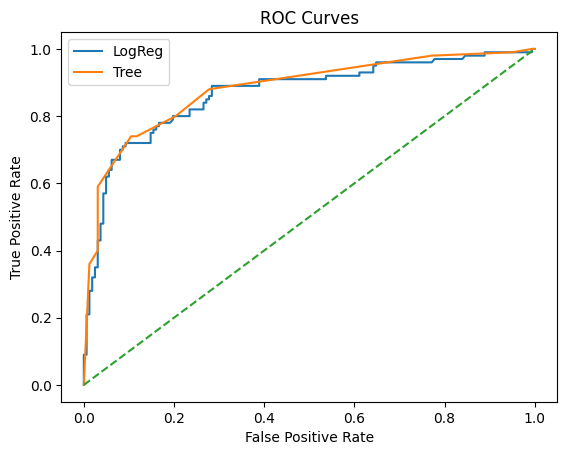

In [11]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, proba)
fpr_tr, tpr_tr, _ = roc_curve(y_test, proba_t)

plt.figure()
plt.plot(fpr_lr, tpr_lr, label="LogReg")
plt.plot(fpr_tr, tpr_tr, label="Tree")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


In [12]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# --- Define column types (match your features) ---
categorical_features = ["sex", "embarked"]
numeric_features = ["pclass", "age", "fare", "sibsp", "parch", "is_child"]

# --- Preprocess: one-hot for categorical, pass-through numeric ---
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features),
    ]
)

# --- Baseline XGBoost ---
xgb_baseline = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,     # L2
    reg_alpha=0.0,      # L1
    random_state=42,
    eval_metric="logloss",
    n_jobs=-1
)

xgb_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", xgb_baseline)
])

xgb_pipe.fit(X_train, y_train)

proba = xgb_pipe.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, proba)

print("XGBoost baseline ROC-AUC:", auc)


XGBoost baseline ROC-AUC: 0.8911111111111111


In [14]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    max_iter=1000,
    penalty="l2",
    solver="liblinear"
)

logreg_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", logreg)
])

logreg_pipe.fit(X_train, y_train)

proba_lr = logreg_pipe.predict_proba(X_test)[:, 1]
auc_lr = roc_auc_score(y_test, proba_lr)

print("Logistic Regression ROC-AUC:", auc_lr)



Logistic Regression ROC-AUC: 0.8663271604938272


c:\Projects\Machine_Learning\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


In [16]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(
    max_depth=4,
    random_state=42
)

tree_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", tree)
])

tree_pipe.fit(X_train, y_train)

proba_tree = tree_pipe.predict_proba(X_test)[:, 1]
auc_tree = roc_auc_score(y_test, proba_tree)

print("Decision Tree ROC-AUC:", auc_tree)


Decision Tree ROC-AUC: 0.881172839506173


In [20]:
import numpy as np
import pandas as pd

df = pd.read_csv("../data/processed/titanic3_eda.csv")

y = df["survived"]

features = ["pclass","sex","age","fare","sibsp","parch","embarked","is_child"]
X = df[features].copy()


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)



In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

num_features = ["pclass","age","fare","sibsp","parch","is_child"]
cat_features = ["sex","embarked"]

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_features),
    ("cat", categorical_pipe, cat_features),
])


In [23]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    eval_metric="logloss",
    n_jobs=-1
)

xgb_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", xgb)
])


xgb_pipe.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [25]:
proba_xgb = xgb_pipe.predict_proba(X_test)[:, 1]
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, proba_xgb)
print("XGBoost ROC-AUC:", auc)



XGBoost ROC-AUC: 0.8988888888888888


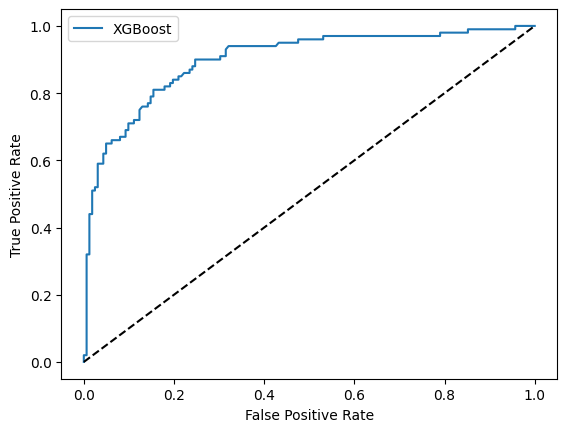

In [26]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, proba_xgb)

plt.plot(fpr, tpr, label="XGBoost")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
